In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from functools import total_ordering
import bisect
from heapq import merge
from collections import Counter

In [4]:
class Pile(list):
    def __lt__(self, other): return self[-1] < other[-1]

    def __eq__(self, other): return self[-1] == other[-1]

## Part 1 - Helping Function

In [5]:
#calculates the last index of helper array = number of stacks
def get_last_idx(arr):
    if not arr: return -1
    i = 0
    while arr[i] != -1:
        i+=1
    
    return arr[i-1]

def get_LIS_by_row(df, idx):
    in_LIS = [0]*df.shape[0]
    while idx != -1:
        in_LIS[idx] = 1
        idx = df.loc[idx, 'angry'] 
    return in_LIS

In [6]:
#make random students
#make the students_df
#sort by gpa
def make_random_students(num_students):
    sat = np.random.randint(200, 801, size=num_students) 
    gpa = np.random.randint(0, 101, size = num_students)

    data_dict = {"gpa" : gpa, "sat" : sat}
    students_df = pd.DataFrame.from_dict(data_dict)

    students_df.sort_values("gpa", inplace = True)
    students_df = students_df.reset_index(drop = True)

    return students_df

In [12]:
#patience sort function - makes the stacks
def patience_sort_df(df, print_piles = 0, col="sat"):
    
    #this is 4 different arrays:
    piles = [] #the length is the number of piles, the number in each col is how many cards in the pile 
    pile_idx = []
    
    angry = [-1]*(df.shape[0])
    helper = [-1]*(df.shape[0])
    
    # sort into piles
    for index, row in df.iterrows():
        x = row["sat"]
        new_pile = Pile([x])

        i = bisect.bisect_right(piles, new_pile) #i is what pile to put the card

        pile_idx.append(i) #counts the number of piles

        #if the number of the pile does not exist - add another pile to piles[]
        if i != len(piles):
            piles[i].append(x)

        #if there is the wanted pile add - in each col there will be the number of cards    
        else:
            piles.append(new_pile)

        #this is the base for the LIS
        helper[i] = index #saves the last index of card in each pile 
        if i:
            angry[index] = helper[i-1] #after putting a card in the stack saves who was he angry about 

    
    #print("the helper is :" ,helper)
    last_idx = get_last_idx(helper) #gets the last index of the helper array = number of stacks
    #print("ths last index is:" ,last_idx)
    if print_piles: print(piles) 
    return (pile_idx, angry, last_idx) ## return: 1.number of piles ??, 2.the angry array, 3.number of piles ?? 

In [13]:
#makes the df_diamond
def diamond_branch(df):
    #1.make df_diamond
    df_diamond = df.copy(deep=True)
    in_diamond = [0]*df.shape[0]
    for index, row in df.iterrows():
        sat = row["sat"]
        gpa = row["gpa"]
        if (((sat-6*gpa) < 500) & ((sat+6*gpa) < 1100) & ((sat-6*gpa) > -100) & ((sat+6*gpa) > 500)):
            in_diamond[index] = 1
            
    df_diamond['in_diamond'] = in_diamond #add col
    df_diamond = df_diamond[df_diamond['in_diamond']>0] #leave only thoser that have 1
    df_diamond = df_diamond.drop('in_diamond', axis=1) #erases in_diamond col
    df_diamond = df_diamond.reset_index(drop=True)
    
    #2.call patience sort
    piles_idx, angry, last_idx = patience_sort_df(df_diamond, print_piles=0)
    df_diamond['pile'] = piles_idx
    df_diamond['angry'] = angry
    #put 1 if the number is part of the LIS
    in_LIS = get_LIS_by_row(df_diamond, last_idx)
    df_diamond['LIS'] = in_LIS
    return df_diamond

In [14]:
#this function calls make_random_students and patience_sort_df and get_LIS_by_row
def create_scenario(num_students, seed=0, print_piles=0):
    # if we want the same students every time seed needs to be 1
    if seed: 
        np.random.seed(seed)
    
    #makes the student_df (next function)
    students_df = make_random_students(num_students)
    df_diamond = diamond_branch(students_df)
    
    piles_idx, angry, last_idx = patience_sort_df(students_df, print_piles=0)
    
    #glue to the df 2 new col: 1.the pile of each card 2. who is he angry at 
    students_df['pile'] = piles_idx
    students_df['angry'] = angry
    
    #put 1 if the number is part of the LIS
    in_LIS = get_LIS_by_row(students_df, last_idx)
    students_df['LIS'] = in_LIS
    return students_df, df_diamond

In [15]:
def delete_piles(df, devided_by, copy = 0):
    if copy:
        df_new_piles = df.copy(deep=True)
    else:
        df_new_piles = df
    dict_map = {}
    piles_max = max(df['pile'])+1
    for i in range(piles_max):
        if i%devided_by:
            dict_map[i] = -1
        else:
            dict_map[i] = i
    df_new_piles['pile'] = df_new_piles['pile'].map(dict_map)
    return df_new_piles

## Part 2 - Students Relative Geometry

In [93]:
num_students = 100000
students_df, df_diamond = create_scenario(num_students, print_piles=0)
students_df

,gpa,sat,pile,angry,LIS
0,0,419,0,-1,0
1,0,638,1,0,0
2,0,353,0,-1,0
3,0,429,1,2,0
4,0,646,2,3,0
...,...,...,...,...,...
99995,100,762,768,99916,0
99996,100,486,597,99784,0
99997,100,326,438,99515,0
99998,100,641,696,99507,0


In [94]:
print("number of piles: ", (max(students_df['pile'])+1))

number of piles:  789


In [95]:
LIS_df = students_df[(students_df['LIS'] == 1)]
LIS_df = LIS_df.drop(['pile','angry','LIS'], axis=1, inplace=False)
LIS_df.head(3)

,gpa,sat
95,0,200
221,0,201
682,0,201


In [96]:
students_df_dp = delete_piles(students_df, 10, copy = 1)
students_df_dp

,gpa,sat,pile,angry,LIS
0,0,419,0,-1,0
1,0,638,-1,0,0
2,0,353,0,-1,0
3,0,429,-1,2,0
4,0,646,-1,3,0
...,...,...,...,...,...
99995,100,762,-1,99916,0
99996,100,486,-1,99784,0
99997,100,326,-1,99515,0
99998,100,641,-1,99507,0


Text(0.5, 0, 'GPA score')

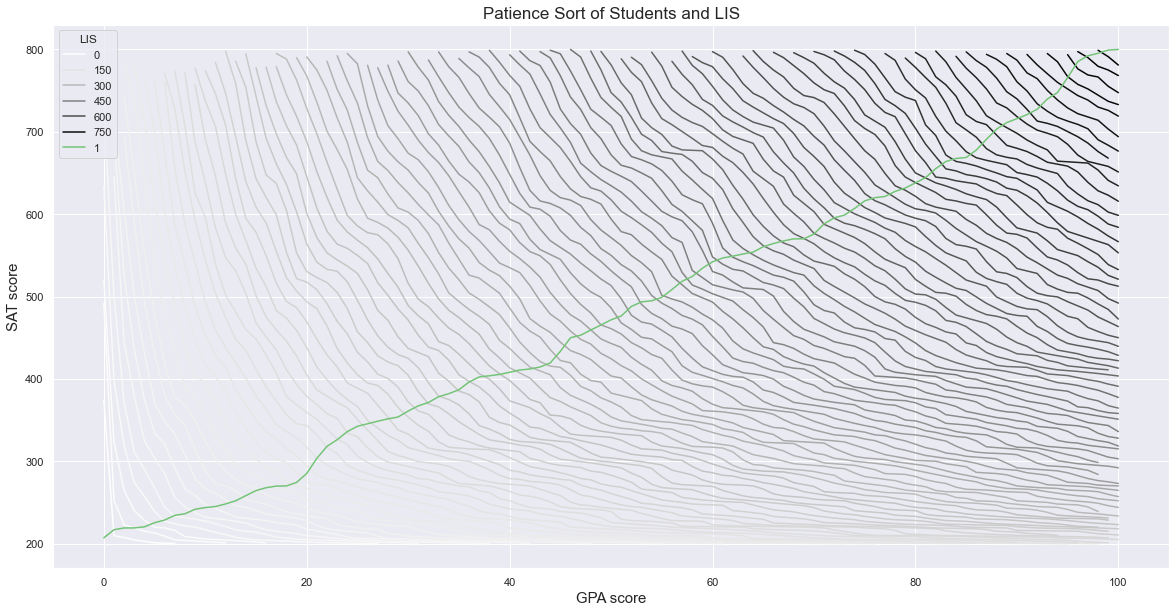

In [97]:
#printing regular patience sort
sns.lineplot(data=students_df_dp.query("pile >= 0"), x="gpa", y="sat", hue="pile", palette=('Greys'), markers = True, ci= None)
sns.lineplot(data=students_df_dp.query("LIS == 1"), x="gpa", y="sat", hue="LIS", palette=('Greens'), ci= None)
sns.set(rc = {'figure.figsize':(20,10)})
plt.title('Patience Sort of Students and LIS', size = 17)
plt.ylabel('SAT score', size = 15)
plt.xlabel('GPA score', size = 15)

## Part 3 - Diamond Relative Geometry

In [98]:
df_diamond.head()

,gpa,sat,pile,angry,LIS
0,1,504,0,-1,0
1,1,503,0,-1,0
2,1,495,0,-1,0
3,1,495,1,2,0
4,1,496,2,3,0


In [101]:
#leave only 1 out of 10 for picture
df_diamond_dp = delete_piles(df_diamond, 10, copy = 1)

# להוסיף פה הגדרה קבועה של גודל הצירים

Text(0.5, 0, 'GPA score')

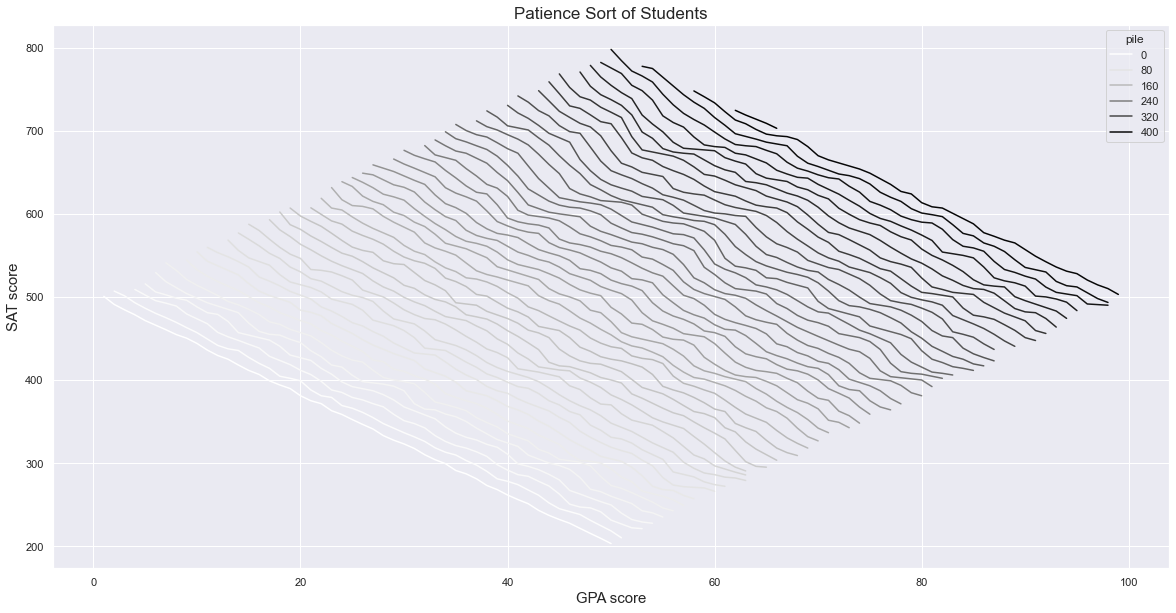

In [102]:
#printing diamond patience sort
sns.lineplot(data=df_diamond_dp.query("pile >= 0"), x="gpa", y="sat", hue="pile", palette=('Greys'), markers = True, ci= None)
#sns.scatterplot(data=df_diamond.query("pile >= 0"), x="gpa", y="sat", hue="pile", palette=('Greys'), markers = True, ci= None)
sns.set(rc = {'figure.figsize':(20,10)})
plt.title('Patience Sort of Students', size = 17)
plt.ylabel('SAT score', size = 15)
plt.xlabel('GPA score', size = 15)
#plt.plot('gpa', 'sat', data=LIS_df), linewidth=2)

## Part 4 - Piles statistics - how many piles in a run

In [105]:
#like main
count_piles, count_piles_d = [], []
num_trials = 50
for i in range(num_trials):
    students_df ,df_diamond = create_scenario(num_students = 10000, print_piles=0) #makes the two df
    count_piles.append(max(students_df['pile'])+1)
    count_piles_d.append(max(df_diamond['pile'])+1)

    
#making the first hist
hist_dict = {'trial': range(num_trials), 'piles': count_piles, 'piles_diamond': count_piles_d}
df_hist = pd.DataFrame.from_dict(hist_dict)
df_hist.head()

,trial,piles,piles_diamond
0,0,213,107
1,1,206,115
2,2,220,110
3,3,208,111
4,4,209,115


Text(0.5, 0, '# of Piles')

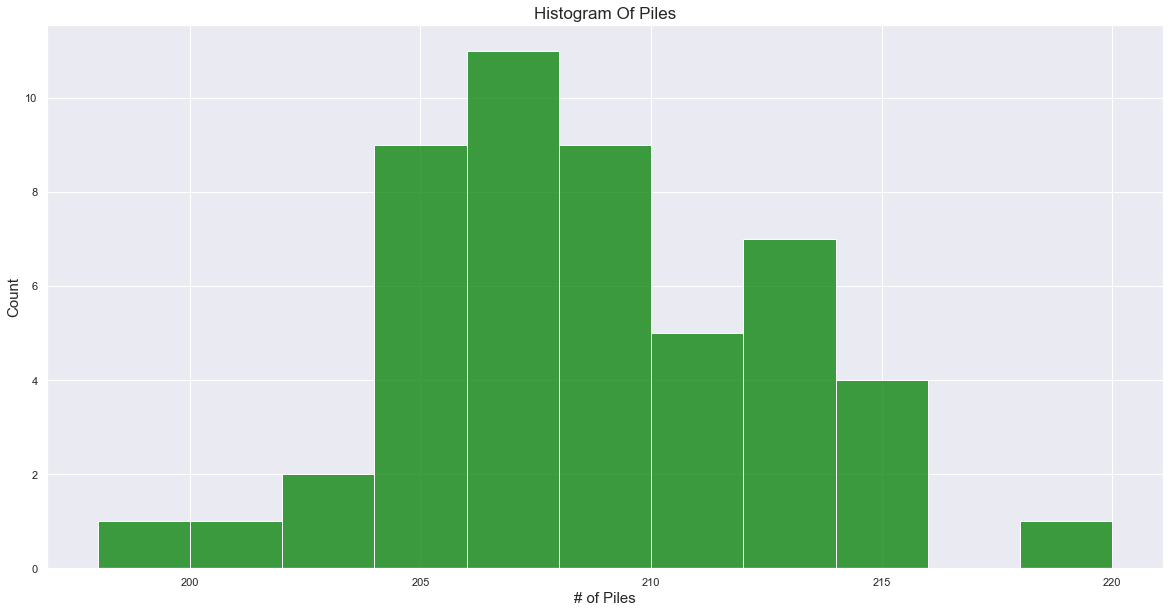

In [106]:
# prints regular hist (*100)
sns.histplot(data = df_hist, x='piles', binwidth = 2, color = "green")
sns.set(rc = {'figure.figsize':(20,10)})
plt.title('Histogram Of Piles', size = 17)
plt.ylabel('Count', size = 15)
plt.xlabel('# of Piles', size = 15)

Text(0.5, 0, '# of Piles')

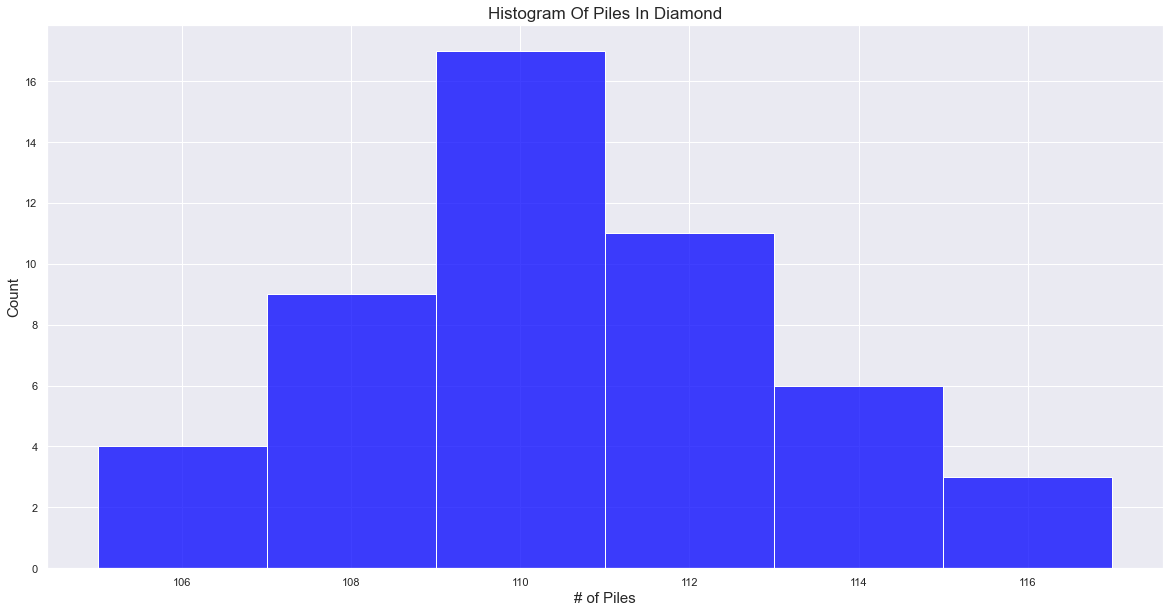

In [107]:
# prints diamond hist (*100)
sns.histplot(data = df_hist, x='piles_diamond', binwidth = 2,  color = "blue")
sns.set(rc = {'figure.figsize':(20,10)})
plt.title('Histogram Of Piles In Diamond', size = 17)
plt.ylabel('Count', size = 15)
plt.xlabel('# of Piles', size = 15)

## Part 5 - Piles statistics - how many crads in each pile

In [108]:
#new main
pile, cards_in_pile, trial = [], [], []
pile_d, cards_in_pile_d, trial_d = [], [], []
num_trials = 20
for i in range(num_trials):
    #regular students:
    students_df, df_diamond = create_scenario(num_students = 10000, print_piles=0)
    
    trial_counter = Counter(list(students_df['pile'])) # makes a counter object every pile how many cards in it 
    cards_in_pile = cards_in_pile + list(trial_counter.values()) # makes a counter object every pile how many cards in it  
    pile = pile + list(trial_counter.keys()) 
    trial = trial + [i]*len(trial_counter.values()) 
    
    trial_counter_d = Counter(list(df_diamond['pile'])) # makes a counter object every pile how many cards in it 
    cards_in_pile_d = cards_in_pile_d + list(trial_counter_d.values()) # makes a counter object every pile how many cards in it 
    pile_d = pile_d + list(trial_counter_d.keys()) 
    trial_d = trial_d + [i]*len(trial_counter_d.values()) 

#making the dicts and df towards printing
cards_dict = {'trial':trial, 'pile': pile, 'cards':cards_in_pile}
cards_df = pd.DataFrame.from_dict(cards_dict)
cards_d_dict = {'trial':trial_d, 'pile': pile_d, 'cards':cards_in_pile_d}
cards_d_df = pd.DataFrame.from_dict(cards_d_dict)

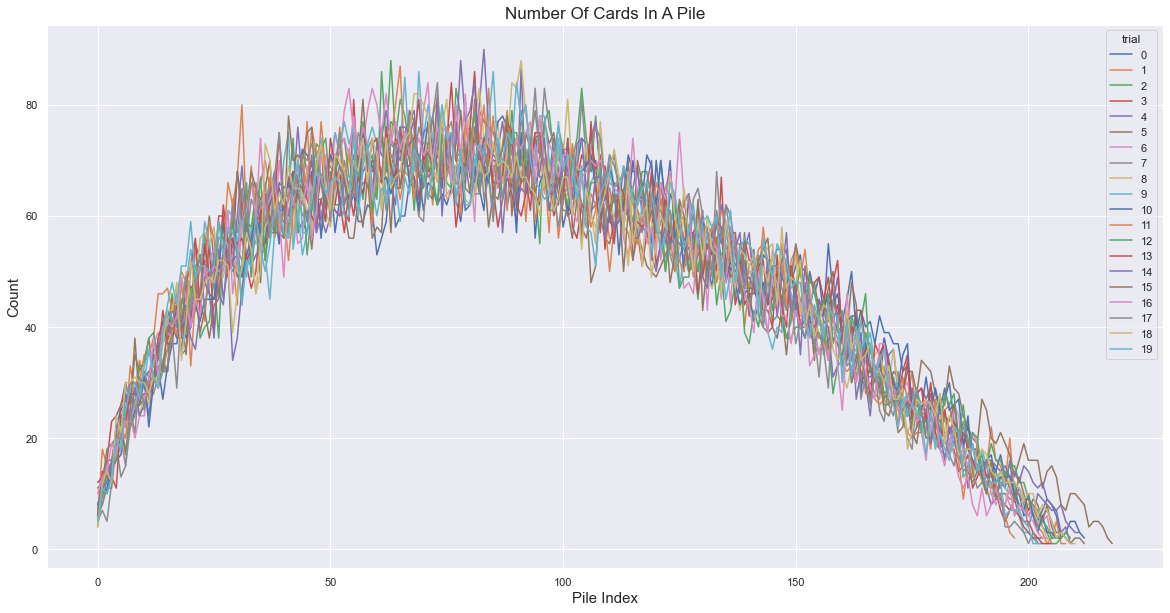

In [109]:
#print number of cards in pile regular students
sns.lineplot(data=cards_df, x="pile", y="cards", hue="trial",  palette="deep", markers=True)
sns.set(rc = {'figure.figsize':(20,10)})
plt.title('Number Of Cards In A Pile', size = 17)
plt.ylabel('Count', size = 15)
plt.xlabel('Pile Index', size = 15)
ax.set_xticks(range(0,max(pile),50));

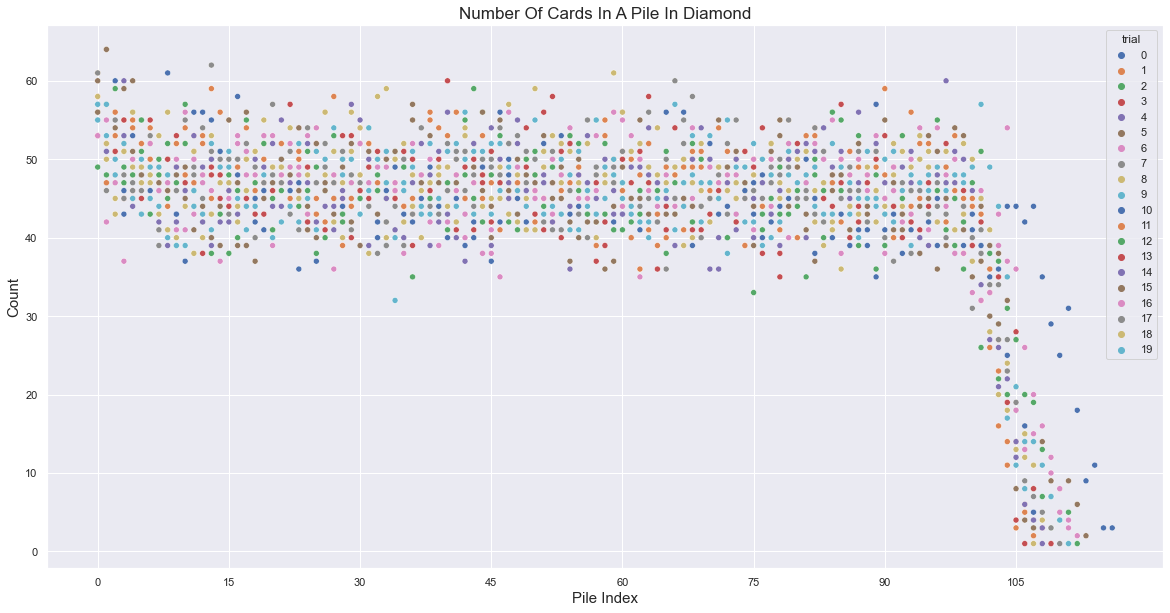

In [110]:
#print number of cards in pile diamond students 
fig, ax = plt.subplots()
#sns.lineplot(data=cards_d_df, x="pile", y="cards", hue="trial",  palette="deep", markers=True)
sns.scatterplot(data=cards_d_df.query("pile >= 0"), x="pile", y="cards", hue="trial",  palette="deep", markers=True)
sns.set(rc = {'figure.figsize':(20,10)})
plt.title('Number Of Cards In A Pile In Diamond', size = 17)
plt.ylabel('Count', size = 15)
plt.xlabel('Pile Index', size = 15)
ax.set_xticks(range(0,max(pile_d),15));

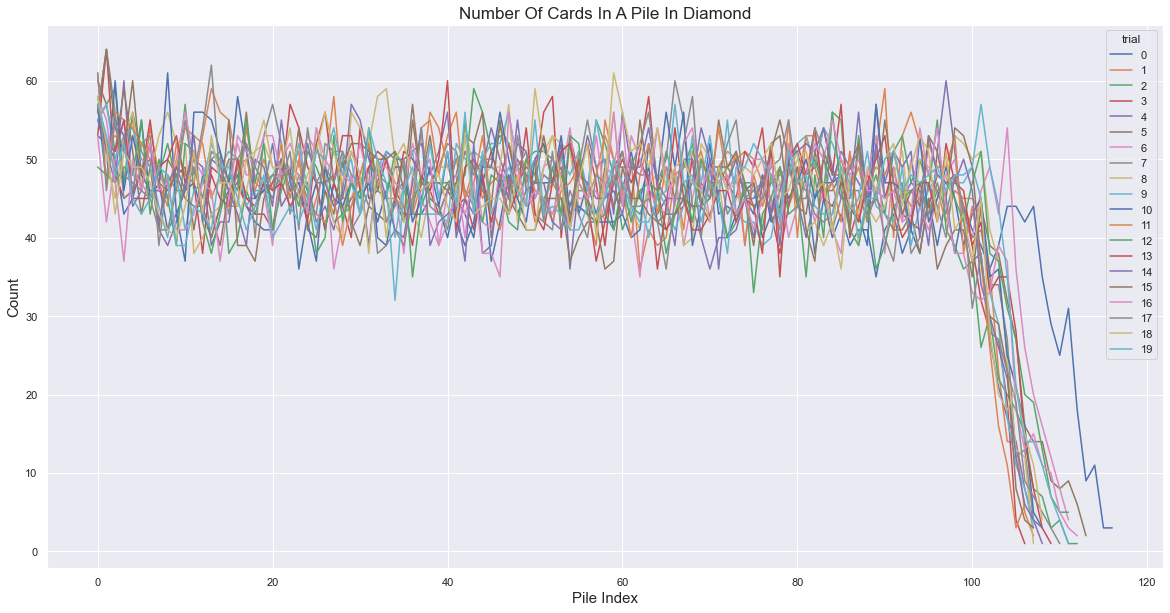

In [111]:
sns.lineplot(data=cards_d_df, x="pile", y="cards", hue="trial",  palette="deep", markers=True)
sns.set(rc = {'figure.figsize':(20,10)})
plt.title('Number Of Cards In A Pile In Diamond', size = 17)
plt.ylabel('Count', size = 15)
plt.xlabel('Pile Index', size = 15)
ax.set_xticks(range(0,max(pile_d),15));

## Part 6 - Anti-diagonal Patience Sort 

#### Helping Functions

In [112]:
#patience sort function - makes the stacks
def patience_sort_2_piles(df, print_piles = 0, col="sat", gpa_high = 0):
    
    #this is 2 different arrays:
    piles = [] #the length is the number of piles, the number in each col is how many cards in the pile 
    pile_idx = []

    # sort into piles from lowest gpa
    if gpa_high == 0:
        for index, row in df.iterrows():
            x = row[col]
            new_pile = Pile([x])

            i = bisect.bisect_right(piles, new_pile) #i is what pile to put the card

            pile_idx.append(i) #counts the number of piles
            #if the number of the pile does not exist - add another pile to piles[]
            if i != len(piles):
                piles[i].append(x)
            #if there is the wanted pile add - in each col there will be the number of cards    
            else:
                piles.append(new_pile)

    # sort into piles from highest gpa
    else:
        #for index, row in df[::-1].iterrows():
        for index, row in df.iterrows():
            #print("-D- i: {} sat: {} gpa: {}".format(index, row["sat"], row["gpa"]))
            x = row['sat_opp']
            new_pile = Pile([x])

            i = bisect.bisect_right(piles, new_pile) #i is what pile to put the card
            #print("-D- i: {} sat: {} gpa: {} pile: {}".format(index, row["sat"], row["gpa"], i))

            pile_idx.append(i) #counts the number of piles

            #if the number of the pile does not exist - add another pile to piles[]
            if i != len(piles):
                piles[i].append(x)

            #if there is the wanted pile add - in each col there will be the number of cards    
            else:
                piles.append(new_pile)
        
    #if print_piles: print(piles) 
    return pile_idx ## return: 1.number of piles ??, 2.the angry array, 3.number of piles ?? 

In [113]:
def split_AD(df):
    df_selection = [1]*df.shape[0]
    for index, row in df.iterrows():
        if (row["sat"]+6*row["gpa"]) < 800:
            df_selection[index] = 2
    #print(df_selection)
    df['df_selection'] = df_selection #add col
    df1, df2 = df.copy(), df.copy()
    df1 = df[df['df_selection']<2] #leave only those that have 1
    df1 = df1.drop('df_selection', axis=1) #erases col
    df1 = df1.reset_index(drop=True)
    df2 = df[df['df_selection']>1] #leave only those that have 1
    df2 = df2.drop('df_selection', axis=1) #erases col
    df2 = df2.sort_values("gpa", inplace = False, ascending = False)
    df2 = df2.reset_index(drop=True)
    return df1, df2

In [114]:
#this function calls make_random_students and patience_sort_df and get_LIS_by_row
def create_scenario_AD(num_students, seed=0, print_piles=0):
    # if we want the same students every time seed needs to be 1
    if seed: 
        np.random.seed(seed)
    
    #makes the student_df
    students_df = make_random_students(num_students) 
    df1, df2 = split_AD(students_df)
    #print(" the df2 before patience looks like:\n", df2)

    #df1 actions
    piles_idx = patience_sort_2_piles(df1, print_piles=print_piles)   
    df1['pile'] = piles_idx

    #df2 actions
    df2['sat_opp'] = 800-df2['sat']
    piles_idx_2 = patience_sort_2_piles(df2, print_piles=print_piles, col='sat_opp', gpa_high = 1)
    piles_idx_2 = [(-(i+1)) for i in piles_idx_2]
    df2['pile'] = piles_idx_2
    #print(" the df2 after patience looks like:\n", df2)
    df2 = df2.drop(['sat_opp'], axis=1) #erases sat_opp col
    
    return df1, df2

In [115]:
#like main
#count_piles, count_piles_d = [], []
#num_trials = 1
#for i in range(num_trials):
df1, df2 = create_scenario_AD(num_students = 20000, seed=42, print_piles=1) #makes the two df
df_union = pd.concat([df1, df2])
#df_union_dp = delete_piles(df_union, devided_by=100, copy = 1)
df_union

,gpa,sat,pile
0,1,800,0
1,2,794,0
2,2,800,1
3,2,788,0
4,2,796,1
...,...,...,...
10025,0,283,-133
10026,0,418,-100
10027,0,591,-58
10028,0,691,-28


Text(0.5, 0, 'GPA score')

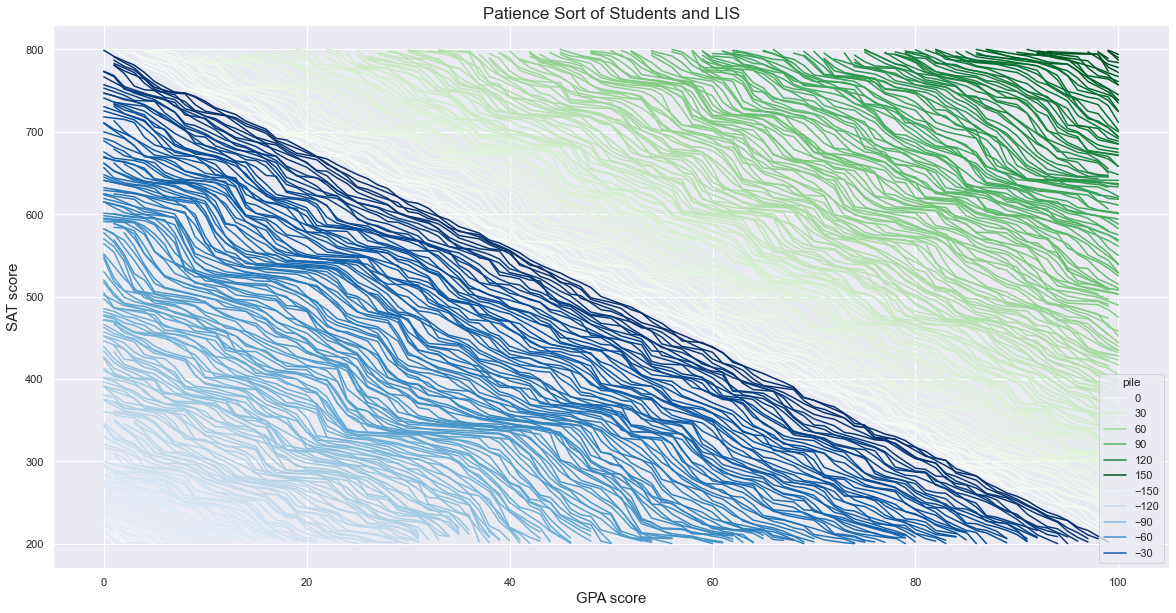

In [116]:
#printing regular patience sort
sns.lineplot(data=df_union.query("pile >= 0"), x="gpa", y="sat", hue="pile", palette=('Greens'), markers = True, ci= None)
sns.lineplot(data=df_union.query("pile < 0"), x="gpa", y="sat", hue="pile", palette=('Blues'), markers = True, ci= None)
sns.set(rc = {'figure.figsize':(20,10)})
plt.title('Patience Sort of Students and LIS', size = 17)
plt.ylabel('SAT score', size = 15)
plt.xlabel('GPA score', size = 15)

# Random Junk

In [ ]:
#new main#new main#new main#new main#new main#new main#new main#new main#new main#new main#new main#new main
pile, cards_in_pile, trial = [], [], []
pile_d, cards_in_pile_d, trial_d = [], [], []
num_trials = 10
for i in range(num_trials):
    #regular students:
    students_df, df_diamond = create_scenario(num_students = 100, print_piles=0)
    
    trial_counter = Counter(list(students_df['pile'])) # makes a counter object every pile how many cards in it 
    cards_in_pile = cards_in_pile + list(trial_counter.values()) # makes a counter object every pile how many cards in it  
    pile = pile + list(trial_counter.keys()) 
    trial = trial + [i]*len(trial_counter.values()) 
    
    trial_counter_d = Counter(list(df_diamond['pile'])) # makes a counter object every pile how many cards in it 
    cards_in_pile_d = cards_in_pile_d + list(trial_counter_d.values()) # makes a counter object every pile how many cards in it 
    pile_d = pile_d + list(trial_counter_d.keys()) 
    trial_d = trial_d + [i]*len(trial_counter_d.values()) 
    
#making the dicts and df towards printing
cards_dict = {'trial':trial, 'pile': pile, 'cards':cards_in_pile}
cards_df = pd.DataFrame.from_dict(cards_dict)
cards_d_dict = {'trial':trial_d, 'pile': pile_d, 'cards':cards_in_pile_d}
cards_d_df = pd.DataFrame.from_dict(cards_d_dict)